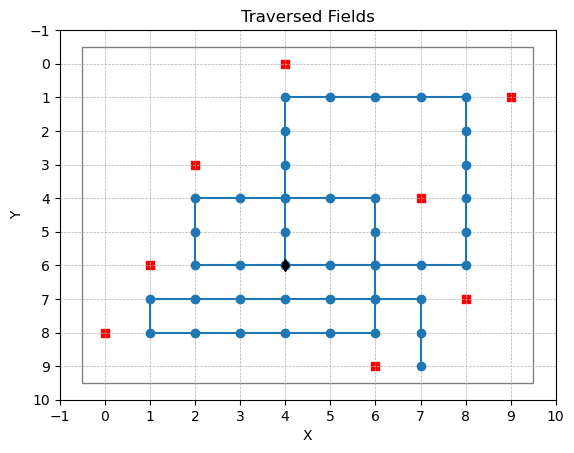

Part 1: 41


In [2]:
import numpy as np
from matplotlib import pyplot as plt

with open("test.txt", "r") as file:
    dmap = [[char for char in line if not char == "\n"] for line in file.readlines()]


Directions = {
        0: np.array([0, -1]), # Up
        1: np.array([1, 0]), # Left
        2: np.array([0, 1]), # Down
        3: np.array([-1, 0])} # Right

class Guard:
    def __init__(self, xi, yi, direction: int):
        self.pos = np.array([xi, yi])
        self.direction = direction
    
    def __repr__(self):
        return f"Guard on [{self.pos}], Facing {Directions[self.direction]}"
    
    def move(self):
        self.pos += Directions[self.direction]
        return self.pos

    def rotate(self, counterclockwise = False):
        if counterclockwise:
            self.direction -= 1
        else:
            self.direction += 1
            
        if self.direction == 4:
            self.direction = 0
        if self.direction == -1:
            self.direction = 3
        return self.direction

    def checkValidMove(self, pos_indexes, mapshape):
        """Returns:
            1 if guard can move forward
            0 if guard cant move forwad
            -1 if guard left the area
        """
        propsedPos = self.pos + Directions[self.direction]
        # print(propsedPos, "=?=", obstacle_indexes)
        px, py = propsedPos
        
        # 1. check if guard is out of bounds
        if not (px >= 0 and py >= 0 and px < mapshape[0] and py < mapshape[1]):
            return -1
        # 1. check if guard is in front of obstacle
        elif np.any(np.all(propsedPos == pos_indexes, axis=1)):
            return 0
        # 2. Guard can move forwad
        else:
            return 1


obstacle_indexes = np.array([])
guard = None
for y, row in enumerate(dmap):
    for x, field in enumerate(row):
        if field == "#":
            if obstacle_indexes.size == 0:
                obstacle_indexes = np.array([x, y])
            else:
                obstacle_indexes = np.vstack([obstacle_indexes, [x, y]])
        if field == "^":
            guard = Guard(x, y, 0)



TraversedEdges = np.array([guard.pos])
while True:
    movestatus = guard.checkValidMove(obstacle_indexes, np.array(dmap).shape)
    if movestatus == 0:
        guard.rotate()
    if movestatus == -1:
        break

    m = guard.move()
    TraversedEdges = np.vstack([TraversedEdges, m]) if TraversedEdges.size else np.array([m])



plt.scatter(np.transpose(obstacle_indexes)[0], np.transpose(obstacle_indexes)[1], marker='s', color="r")
plt.scatter(TraversedEdges[0][0], TraversedEdges[0][1], color="black", zorder=5, marker="d")

plt.plot(TraversedEdges[:, 0], TraversedEdges[:, 1], marker='o')
plt.title('Traversed Fields')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().add_patch(plt.Rectangle((-0.5, -0.5), len(dmap[0]), len(dmap), fill=None, edgecolor='gray', linewidth=1))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().invert_yaxis()
plt.show()

print("Part 1:", len(np.unique(TraversedEdges, axis=0)))


# Time to optimise yeeeey!
`Above code runs in 18 seconds which is unacceptable!`

Instead of moving over each tile, I can compute which obstacle guard is going to hit next->
1. Look at guards direction
2. FInd all obstacles, that are in same direction [eg, direction `(0, 1)` -> search all obstacles with `y` greater than guards y]
3. For all those obstacles, find the one with smallest distance from guard

You now move guard to location one smaller of obstacle in that direction

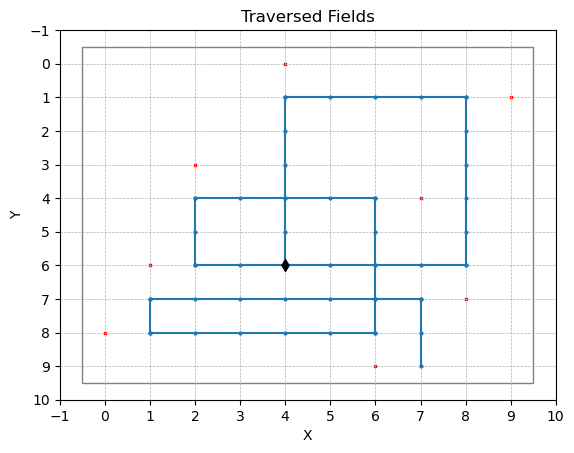

Part 1: 41


In [4]:
import numpy as np
from matplotlib import pyplot as plt

with open("test.txt", "r") as file:
    dmap = [[char for char in line if not char == "\n"] for line in file.readlines()]


Directions = {
        0: np.array([0, -1]), # Up
        1: np.array([1, 0]), # Left
        2: np.array([0, 1]), # Down
        3: np.array([-1, 0])} # Right

class Guard:
    def __init__(self, xi, yi, direction: int):
        self.pos = np.array([xi, yi])
        self.direction = direction

    def __repr__(self):
        return f"Guard on [{self.pos}], Facing {Directions[self.direction]}"

    def move(self):
        self.pos += Directions[self.direction]
        return self.pos

    def rotate(self, counterclockwise = False):
        if counterclockwise:
            self.direction -= 1
        else:
            self.direction += 1

        if self.direction == 4:
            self.direction = 0
        if self.direction == -1:
            self.direction = 3
        return self.direction

    def checkValidMove(self, pos_indexes, mapshape):
        """Returns:
            1 if guard can move forward
            0 if guard cant move forwad
            -1 if guard left the area
        """
        propsedPos = self.pos + Directions[self.direction]
        # print(propsedPos, "=?=", obstacle_indexes)
        px, py = propsedPos

        # 1. check if guard is out of bounds
        if not (px >= 0 and py >= 0 and px < mapshape[0] and py < mapshape[1]):
            return -1
        # 1. check if guard is in front of obstacle
        elif np.any(np.all(propsedPos == pos_indexes, axis=1)):
            return 0
        # 2. Guard can move forwad
        else:
            return 1

    def GetNextPosition(self, Obstacles, mapshape):
        """Returns:
        - next spot guard can move to
        - None if guard goes out of map
        """
        # 1. Look at guards direction
        # 2. FInd all obstacles, that are in same direction [eg, direction `(0, 1)` -> search all obstacles with `y` greater than guards y] but on same x coordinate
        # 3. For all those obstacles, find the one with smallest distance from guard

        relevant_obstacles = np.array([])
        obstacle = np.array([])

        if self.direction == 0:  # Up # take obstacle with biggest y
            relevant_obstacles = Obstacles[(Obstacles[:, 1] < self.pos[1]) & (Obstacles[:, 0] == self.pos[0])]
            if relevant_obstacles.size > 0: # Check is required so we can return non-empty array
                obstacle =  np.array(relevant_obstacles[np.argmax(relevant_obstacles[:, 1])])

        elif self.direction == 1:  # Left # Take smallest x
            relevant_obstacles = Obstacles[(Obstacles[:, 0] > self.pos[0]) & (Obstacles[:, 1] == self.pos[1])]
            if relevant_obstacles.size > 0:
                obstacle =  np.array(relevant_obstacles[np.argmin(relevant_obstacles[:, 0])])

        elif self.direction == 2:  # Down
            relevant_obstacles = Obstacles[(Obstacles[:, 1] > self.pos[1]) & (Obstacles[:, 0] == self.pos[0])]
            if relevant_obstacles.size > 0:
                obstacle =  np.array(relevant_obstacles[np.argmin(relevant_obstacles[:, 1])])

        elif self.direction == 3:  # Right
            relevant_obstacles = Obstacles[(Obstacles[:, 0] < self.pos[0]) & (Obstacles[:, 1] == self.pos[1])]
            if relevant_obstacles.size > 0:
                obstacle =  np.array(relevant_obstacles[np.argmax(relevant_obstacles[:, 0])])

        if obstacle.size> 0:
            return np.array(obstacle) - Directions[guard.direction], False

        # GUARD GOES OUT OF AREA
        if relevant_obstacles.size == 0:
            # Okay so, if he goes out of map, he goes to max or min value in that direction
            x, y = self.pos
            if self.direction == 0: #UP
                return [x, 0], True
            if self.direction == 1: #Left
                return [mapshape[0]-1, y], True
            if self.direction == 2: #Down
                return [x, mapshape[1]-1], True
            if self.direction == 3: #Right
                return [0, y], True

    def GetState(self):
        x, y = self.pos
        return tuple((x, y, self.direction))

obstacle_indexes = np.array([])
guard = None
for y, row in enumerate(dmap):
    for x, field in enumerate(row):
        if field == "#":
            if obstacle_indexes.size == 0:
                obstacle_indexes = np.array([x, y])
            else:
                obstacle_indexes = np.vstack([obstacle_indexes, [x, y]])
        if field == "^":
            guard = Guard(x, y, 0)



TraversedEdges = np.array([guard.pos])

while True:
    next_pos, end = guard.GetNextPosition(obstacle_indexes, np.array(dmap).shape)

    guard.pos = next_pos

    TraversedEdges = np.vstack([TraversedEdges, guard.pos])
    guard.rotate()

    if end:
        break


traversedTiles = []
for i in range(1, len(TraversedEdges)):
    ox, oy = TraversedEdges[i-1]
    cx, cy = TraversedEdges[i]
    num_points = max(abs(cx - ox), abs(cy - oy)) + 1
    traversedTiles.append(np.array(np.transpose([np.linspace(ox, cx, num_points), np.linspace(oy, cy, num_points)])))

traversedTiles = np.concatenate(traversedTiles)

plt.scatter(np.transpose(obstacle_indexes)[0], np.transpose(obstacle_indexes)[1], marker='s', color="r", s=2)
plt.scatter(TraversedEdges[0][0], TraversedEdges[0][1], color="black", zorder=5, marker="d")

plt.plot(traversedTiles[:, 0], traversedTiles[:, 1], marker='o', markersize = 2)
plt.title('Traversed Fields')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().add_patch(plt.Rectangle((-0.5, -0.5), len(dmap[0]), len(dmap), fill=None, edgecolor='gray', linewidth=1))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().invert_yaxis()
plt.show()

print("Part 1:", len(np.unique(traversedTiles, axis=0)))

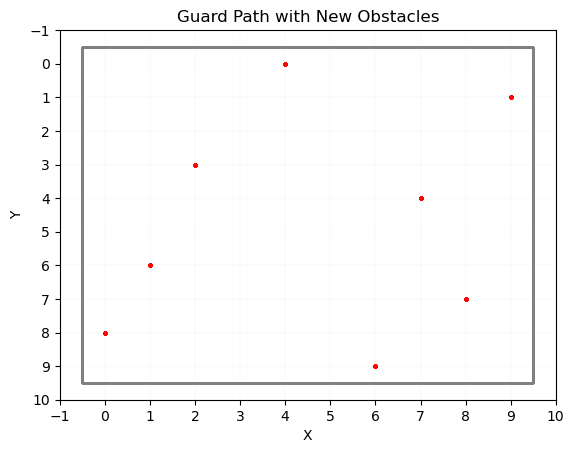

Part 2: 0


In [5]:
### PART 2 ###
# On how many different positions can a single obstacle be placed, so the guard begins walking in circles?

possibleObstacleTiles = []
guard_init = guard


for tile in traversedTiles:
    guard = guard_init
    guardStates = set()

    #reset guard !!!!!!!!!!!!!

    modifiedObstacles = obstacle_indexes.copy()
    modifiedObstacles = np.vstack([modifiedObstacles, tile])

    while True:
        next_pos, end = guard.GetNextPosition(modifiedObstacles, np.array(dmap).shape)

        guard.pos = next_pos

        guardStates.add(guard.GetState())
        guard.rotate()
        
        if end: # Guard left the area
            break
        
        # 2. Check if guard ever returns to the same tile with the same orientation twice
        if guard.GetState() in guardStates: 
            possibleObstacleTiles.append(tile)
            for state in guardStates:
                plt.scatter(tile[0], tile[1], marker='x', s=10, color = "purple")
            break

    
    plt.scatter(np.transpose(obstacle_indexes)[0], np.transpose(obstacle_indexes)[1], marker='s', color="r", s=2)
    plt.title('Guard Path with New Obstacles')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True, which='both', linewidth=0.05)
    plt.gca().add_patch(plt.Rectangle((-0.5, -0.5), len(dmap[0]), len(dmap), fill=None, edgecolor='gray', linewidth=1))
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().invert_yaxis()
plt.show()

print("Part 2:", len(np.unique(possibleObstacleTiles)))